# Аналитика в Яндекс.Афише
## Содержание: <a id='content'></a>
1. [Изучение данных и предобработка](#eda)
2. [Построение отчетов и расчет метрик](#metrics)
   1. [Продукт](#visits)
   2. [Продажи](#orders)
   3. [Маркетинг](#costs)
3. [Вывод и рекомендации](#conclusion)

## 1. Изучение данных и предобработка <a class="anchor" id="eda"></a>

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.float_format = "{:.2f}".format

In [3]:
# загружаем данные
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

Просмотрим таблицы c информацией о посещении сайта, покупках и затратах:

In [4]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [6]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [8]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [9]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Пропущенных значений в данных нет, однако мы видим неудобные названия столбцов в таблицах `visits` и `orders`, а также неверный формат столбцов с датой во всех трех таблицах.  

Предобработку начнём с переименования названия столбцов. Приведем их к нижнему регистру и заменим пробелы на нижнее подчеркивание в качестве разделителя:

In [10]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
orders.columns = ['buy_ts', 'revenue', 'uid']

Теперь преобразуем столбцы с датами и временем к формату *datetime*:

In [11]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

In [12]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [13]:
costs['dt'] = pd.to_datetime(costs['dt'])

В завершении произведем проверку на дубликаты:

In [14]:
visits.duplicated().sum()

0

In [15]:
orders.duplicated().sum()

0

In [16]:
costs.duplicated().sum()

0

Снова применим метод `info` ко всем трем таблицам, чтобы убедиться в правильности предобработки:

In [17]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [18]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [19]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Таким образом мы подготовили данные к дальнейшим исследованиям. Пропущенных значений в них не имеется, столбцы после преобразования имеют нужный нам тип данных, дублирующиеся строки отсутствуют.  
Теперь можем переходить непосредственно к анализу.

## 2. Построение отчетов и расчет метрик.<a class='anchor' id='metrics'></a>
### Продукт <a id='visits'></a>
[Назад к оглавлению](#content)

На первом этапе мы проанализируем метрики по продукту.  
Здесь целью является ответить на следующие вопросы, связанные с использованием сайта:
1. Сколько людей пользуются в день, неделю, месяц?
2. Сколько сессий в день?
3. Сколько длится одна сессия?
4. Как часто люди возвращаются?

Ответом на первый вопрос будет **исследование пользовательской активности**. Для этого применяются 3 основные метрики:
- количество уникальных пользователей в день (DAU);
- количество уникальных пользователей в неделю (WAU);
- количество уникальных пользователей в месяц (MAU).

Для их расчета добавим в тоблицу `visits`  столбцы с годом, месяцем и неделей и днем активности: 

In [20]:
visits['year_ts'] = visits['start_ts'].dt.year
visits['month_ts'] = visits['start_ts'].dt.month
visits['week_ts'] = visits['start_ts'].dt.week
visits['date_ts'] = pd.to_datetime(visits['start_ts'].dt.date)
visits.head()

,device,end_ts,source_id,start_ts,uid,year_ts,month_ts,week_ts,date_ts
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


Чтобы вычислить **DAU**, необходимо сгруппировать таблицу по дате и подсчитать количество уникальных пользователей. После этого найдем их среднее значение и преобразуем его в целое число:

In [21]:
dau_total = visits.groupby('date_ts').agg({'uid':'nunique'}).mean().astype('int')
dau_total

uid    907
dtype: int64

Для расчета **WAU** группировать будем по году и номеру недели, остальные операции аналогичны с предыдущей метрикой:

In [22]:
wau_total = visits.groupby(['year_ts','week_ts']).agg({'uid':'nunique'}).mean().astype('int')
wau_total

uid    5716
dtype: int64

В **MAU** группировка по году и номеру месяца:

In [23]:
mau_total = visits.groupby(['year_ts', 'month_ts']).agg({'uid':'nunique'}).mean().astype('int')
mau_total

uid    23228
dtype: int64

Таким образом средня пользовательская активность распределилась следующим образом:

|Метрика|Среднее значение, чел|
|---|---------------------------|
|Дневная пользовательская активность (DAU)|907|
|Недельная пользовательская активность (WAU)|5716|
|Месячная пользовательская активность (MAU)|23228|

Теперь узнаем сколько в среднем сессий пользователи совершают ежедневно. Сгруппируем таблицу по дате и подсчитаем количество значений в столбце `start_ts`:

In [24]:
sessions_count = visits.groupby('date_ts').agg({'start_ts':'count'})
sessions_count.head()

,start_ts
date_ts,
2017-06-01,664
2017-06-02,658
2017-06-03,477
2017-06-04,510
2017-06-05,893


Посмотрим на распределение и найдем среднее значение:

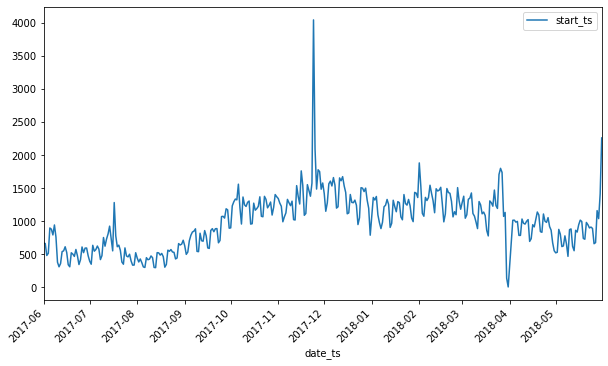

In [25]:
sessions_count.plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.show()

In [26]:
sessions_count.mean()

start_ts   987.36
dtype: float64

На распределении выделяются два скачка - первый был зафиксирован в ноябре 2017, когда сайт посетили около 4000 раз, следующий заметный скачок произошел в конце марта 2018 года, когда на сайт зашли только один раз.  
**Среднее количество сессий в день составляет 987**.

Определим **продолжительность одной сессии (ASL)**. Найдем разность между временем окончания сессии и ее началом. Значение укажем в минутах и запишем их в отдельный столбец:

In [27]:
visits['duration_ts'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
# переведем значения в минуты и сделаем целым числом
visits['duration_ts'] = (visits['duration_ts'] / 60).astype('int')
visits.head()

,device,end_ts,source_id,start_ts,uid,year_ts,month_ts,week_ts,date_ts,duration_ts
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,18
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,28
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,24
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0


In [28]:
visits['duration_ts'].describe()

count   359400.00
mean        10.72
std         16.94
min          0.00
25%          2.00
50%          5.00
75%         14.00
max       1408.00
Name: duration_ts, dtype: float64

Среднее значение составляет почти 11 минут, медианное - ровно 5. Посмотрим на распределение:

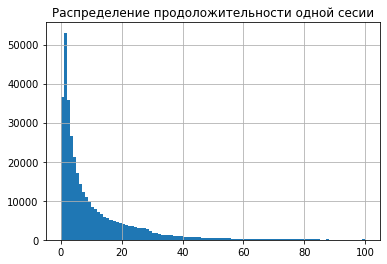

In [29]:
visits['duration_ts'].hist(bins=100, range=[0, 100])
plt.title('Распределение продоложительности одной сесии')
plt.show()

Такое распределение мы не можем назвать нормальным, а значит использовать для его описания среднее или медианное значение будет некорректно. В этих случаях наилучшей мерой центральной тенденции послужит мода:

In [30]:
visits['duration_ts'].mode()

0    1
dtype: int64

Таким образом средняя продолжительность одной сессии составляет одну минуту.  
**ASL = 1**

Следующим шагом будет узнать как часто люди возвращаются на сайт. Данный показатель оценивает метрика Retension Rate (коэффициент удержания).  
Метрика применима для когортного анализа, поэтому прежде чем ее посчитать, нам необходимо разделить пользователей по когортам. Одна когорта будет включать в себя пользователей, которые впервые зашли на сайт в определенный месяц года.  
Определим дату и время первой активности для каждого пользователя:

In [31]:
first_activity = visits.groupby('uid')['start_ts'].min()
first_activity

uid
11863502262781         2018-03-01 17:27:00
49537067089222         2018-02-06 15:55:00
297729379853735        2017-06-07 18:47:00
313578113262317        2017-09-18 22:49:00
325320750514679        2017-09-30 14:29:00
                               ...        
18446403737806311543   2017-11-30 03:36:00
18446424184725333426   2017-12-06 20:32:00
18446556406699109058   2018-01-01 16:29:00
18446621818809592527   2017-12-27 13:27:00
18446676030785672386   2017-10-04 16:01:00
Name: start_ts, Length: 228169, dtype: datetime64[ns]

In [32]:
# переименуем Series, чтобы его название не совпадало с названием столбца в таблице
first_activity.name = 'first_activity'

In [33]:
# добавляем полученный Series в таблицу по номеру пользователя
visits = visits.join(first_activity, on='uid')

In [34]:
visits.head()

,device,end_ts,source_id,start_ts,uid,year_ts,month_ts,week_ts,date_ts,duration_ts,first_activity
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,18,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,28,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,24,2018-03-09 20:05:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0,2017-12-27 14:06:00


Получим месяц активности пользователя, а так же месяц его первой активности:

In [35]:
visits['activity_month'] = visits['date_ts'].astype('datetime64[M]')
visits['first_activity_month'] = visits['first_activity'].astype('datetime64[M]')

Для каждый когорты определим **срок ее "жизни"**. Он представляет собой порядковый номер месяца с момента начала существования когорты.  
Для его нахождения вычтем месяц первой активности из месяца текущей активности и разделим результат на константу `np.timedelta64(1, 'M')`, означающая среднюю продолжительность месяца в году. Чтобы возвращался порядковый номер месяца жизни, округлим полученное значение и преобразуем в целочисленный тип:

In [36]:
visits['first_activity_month'] = visits['first_activity'].astype('datetime64[M]')

In [37]:
visits['cohort_lifetime'] = (((visits['activity_month'] - visits['first_activity_month']) 
                              / np.timedelta64(1, 'M'))
                             .round()
                             .astype('int'))

Чтобы сформировать когорты, сгруппируем таблицу по первому месяцу активности и lifetime и подсчитаем количество уникальных пользователей в каждой группе:

In [38]:
cohorts = (visits
           .groupby(['first_activity_month', 'cohort_lifetime'])
           .agg({'uid':'nunique'})
           .reset_index()
          )
cohorts.head()

,first_activity_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


Для каждой когорты определим начальное число пользователей. Оно будет равно количеству пользователей на нулевой lifetime:

In [39]:
initial_users_count = cohorts[cohorts['cohort_lifetime']==0][['first_activity_month', 'uid']]
# переименуем столбцы
initial_users_count.columns = ['first_activity_month', 'cohort_users']

Объединим таблицы с когортами и начальным числом пользователей по столбцу первой активности:

In [40]:
initial_users_count.columns = ['first_activity_month', 'cohort_users']

In [41]:
cohorts = cohorts.merge(initial_users_count, on='first_activity_month' )

Чтобы вычислить Retension Rate, разделим число пользователей когорты на каждом lifetime на начальное количество пользователей этой когорты:

In [42]:
cohorts['retension'] = cohorts['uid'] / cohorts['cohort_users']

In [43]:
cohorts.head()

,first_activity_month,cohort_lifetime,uid,cohort_users,retension
0,2017-06-01,0,13259,13259,1.00
1,2017-06-01,1,1043,13259,0.08
2,2017-06-01,2,713,13259,0.05
3,2017-06-01,3,814,13259,0.06
4,2017-06-01,4,909,13259,0.07


Для более удобного отображения на графике, в столбце с датой оставим только год и номер месяца:

In [44]:
cohorts['first_activity_month'] = cohorts['first_activity_month'].dt.strftime('%Y-%m')

Наконец, сформируем сводную таблицу, где в качестве индексов будут представлены когорты, а в колонках будет указана продолжительность ее жизни. В значениях укажем суммарный retension:

In [45]:
retension_pivot = cohorts.pivot_table(index='first_activity_month', 
                                      columns='cohort_lifetime', 
                                      values='retension', 
                                      aggfunc='sum')

Построим тепловую карту по полученной таблице:

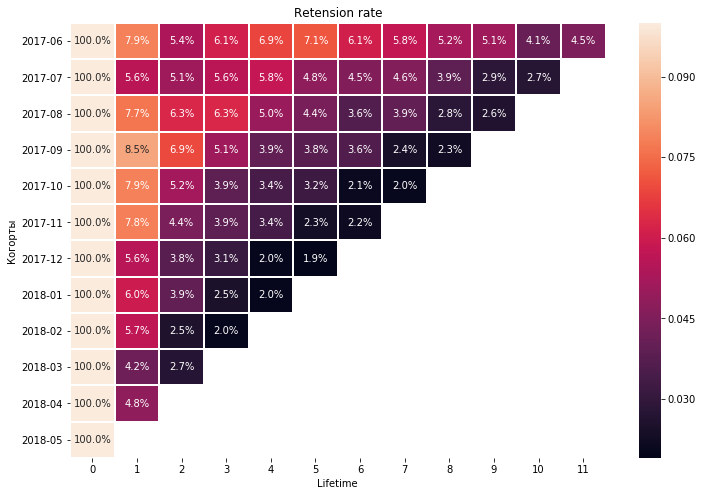

In [46]:
plt.figure(figsize=(12, 8))
sns.heatmap(retension_pivot, 
            annot=True, 
            fmt='.1%', 
            linewidths=1, 
            linecolor='white',
            vmax=0.1) #vmax указывает, что максимальное значение данных не превышает заданного
plt.title('Retension rate')
plt.xlabel('Lifetime')
plt.ylabel('Когорты')
plt.show()

В целом мы можем наблюдать тенденцию к снижению Retension Rate по кагортам. Наибольший процент сохраненных пользователей на второй месяц наблюдается по сентябрьской когорте - 8,5%. К концу исследуемого периода во всех когортах кроме первой процент пользователей не превышает 3 от изначального числа. Примечательно, что в мае 2018 этот процент был примерно одинаковым для первой и последней когорт. Также в каждой когорте процент пользователей практически стабильно уменьшается на протяжении ее жизненного цикла; исключением является лишь первая - здесь, начиная с 4 месяца, наблюдался прирост, который достиг пика в ноябре 2018 и вновь пошел на убыль.  
Такие низкие показатели говорят нам о том, что юзеры, как правило, пользуются сервисом единожды.

Подводя итог расчета и исследования метрик по продукту, выведем их значения в сводную таблицу:
    
|Метрика|Значение|
|---|---------------------------|
|Дневная пользовательская активность (DAU)|907 чел|
|Недельная пользовательская активность (WAU)|5716 чел|
|Месячная пользовательская активность (MAU)|23228 чел|  
|Среднее количество сессий в день|987|
|Средняя продолжительность одной сессии (ASL)|1 мин|

### Продажи <a id='orders'></a>
[Назад к оглавлению](#content)

На следующем этапе мы узнаем когда люди начинают покупать, сколько покупок совершают за период, каков средний чек, а также сколько приносят денег.  
Вспомним, как выглядит таблица с заказами:

In [47]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Первым делом выясним, сколько проходит времени с момента первого визита пользователя на сайт до момента первой его покупки.  
Сгруппируем исходную таблицу с заказами по идентификатору пользователя и найдем для каждого дату и время первой покупки:

In [48]:
first_order = (orders
               .groupby('uid')['buy_ts']
               .min()
               .reset_index()
               .rename(columns={'buy_ts':'first_buy'})
              )
first_order.head()

,uid,first_buy
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


Объединим полученную таблицу с Series `first_activity`, которую мы использовали в предыдущем шаге. В ней для каждого пользователя указано дата и время первого визита.

In [49]:
first_order = first_order.merge(first_activity, on='uid', how='left')
first_order.head()

,uid,first_buy,first_activity
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


Добавим столбец с интересующей нас разницей, которая получится путем вычета времени первой активности из времени первого заказа. Преобразуем полученный результат в минуты константой `np.timedelta64(1, 'm')`:

In [50]:
first_order['order_timedelta'] = (((first_order['first_buy'] - first_order['first_activity']) 
                                   / np.timedelta64(1, 'm'))
                                  .astype('int'))
first_order.head()

,uid,first_buy,first_activity,order_timedelta
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,154022
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,79
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,1184
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0


Изучим среднее и медианное значения:

In [51]:
first_order['order_timedelta'].describe()

count    36523.00
mean     24340.18
std      67784.77
min          0.00
25%          4.00
50%         16.00
75%       2897.00
max     523144.00
Name: order_timedelta, dtype: float64

Медианное время покупки - 16 минут. Среднее же очень сильно от него отклоняется, что указывает на явные выбросы в значениях.  
Для определения этих выбросов построим график boxplot:

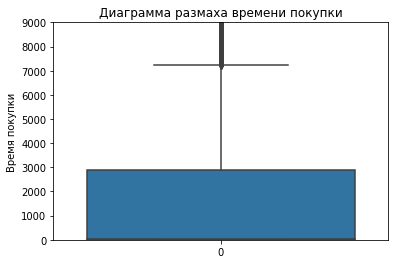

In [52]:
plt.ylim(0, 9000)
sns.boxplot(data = first_order['order_timedelta'])
plt.title('Диаграмма размаха времени покупки')
plt.ylabel('Время покупки')
plt.show()

Выбросы начинаются после 7000 минут. Среднее значение превышает этот показатель более чем в 3 раза.

Построим распределение времени:

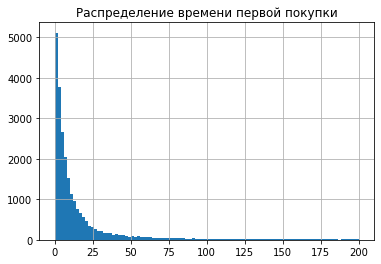

In [53]:
first_order['order_timedelta'].hist(bins=100, range=(0,200))
plt.title('Распределение времени первой покупки')
plt.show()

Как и в случае с продолжительностью сессии, исходя из такого распределения, нам следует использовать моду. 

In [54]:
first_order['order_timedelta'].mode()

0    1
dtype: int64

Таким образом большинство пользователей совершают первую покупку уже спустя минуту после захода на сайт.

Далее мы подсчитаем, **сколько раз покупают за период**. Для этого сгруппируем исходную таблицу по пользователям, найдем количество покупок по каждому и посмотрим на распределение:

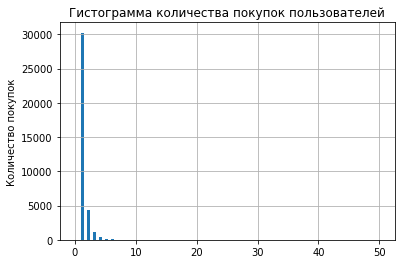

In [55]:
orders_per_user = orders.groupby('uid').agg({'buy_ts':'count'})
orders_per_user.hist(bins=100, range=(0,50))
plt.title('Гистограмма количества покупок пользователей')
plt.ylabel('Количество покупок')
plt.show()

Вновь исследуем моду:

In [56]:
orders_per_user['buy_ts'].mode()

0    1
dtype: int64

Чаще всего **каждый пользователь совершает только одну покупку** за все время исследовательского периода.

Рассмотрим также сколько всего покупок приходится в месяц и неделю от всех пользователей в среднем. Выделим в исходной таблице столбцы с годом, месяцкм и номером недели покупки: 

In [57]:
orders['buy_year'] = orders['buy_ts'].dt.year
orders['buy_month_num'] = orders['buy_ts'].dt.month
orders['buy_week_num'] = orders['buy_ts'].dt.week

In [58]:
orders.head()

,buy_ts,revenue,uid,buy_year,buy_month_num,buy_week_num
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017,6,22
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017,6,22
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017,6,22
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017,6,22
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017,6,22


Получим количество заказов путем группировки таблицы по году и номеру месяца и посчитаем количество строк в каждой группе. После этого посмотрим на распределение полученных значений:

In [59]:
orders_per_month = orders.groupby(['buy_year', 'buy_month_num'])['buy_ts'].count()

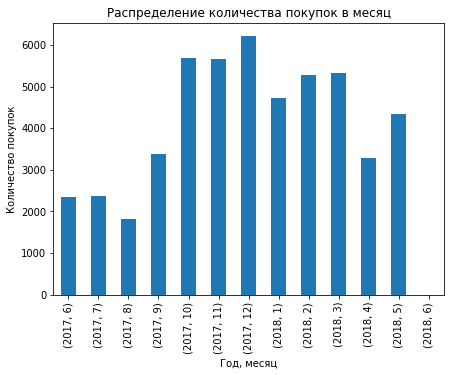

In [60]:
orders_per_month.plot(kind='bar', figsize=(7,5))
plt.title('Распределение количества покупок в месяц')
plt.xlabel('Год, месяц')
plt.ylabel('Количество покупок')
plt.show()

Здесь мы можем наблюдать повышение спроса в осенние и зимние месяцы - наибольшее значение (около 6000 покупок) было зафиксировано в декабре. С октябра по март значения так же достаточно высоки и варьируются в районе 5000.  
Летом, напротив, значения минимальны - порядка 2000, меньше всего покупок люди совершали в августе.  

Найдем среднее число заказов:

In [61]:
orders_per_month.mean().astype('int')

3878

**Среднее количество заказов в месяц - 3878**.

Посмотрим на распределение количества покупок в неделю и вычислим среднее значение. Для этого будем производить группировку по стоолбцам `buy_year` и `buy_week_num`:

In [62]:
orders_per_week = orders.groupby(['buy_year', 'buy_week_num'])['buy_ts'].count()

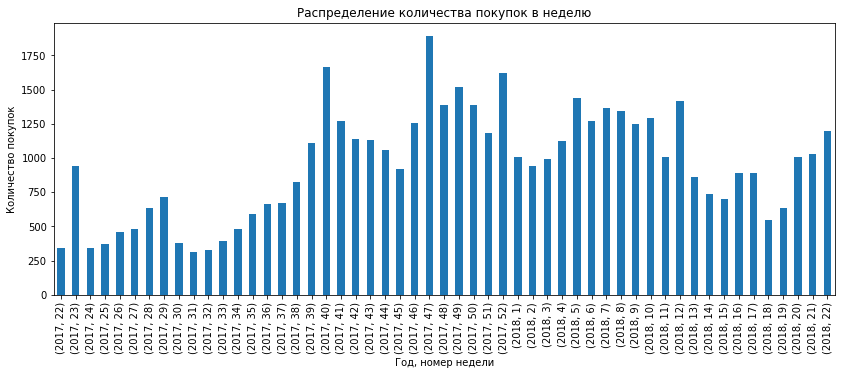

In [63]:
orders_per_week.plot(kind='bar', figsize=(14,5))
plt.title('Распределение количества покупок в неделю')
plt.xlabel('Год, номер недели')
plt.ylabel('Количество покупок')
plt.show()

In [64]:
orders_per_week.mean().astype('int')

951

Здесь стабильный рост наблюдается с августа 2017 (столбец (2017, 32)) и достигает первого пика в октябре со значением около 1700 заказов. Далее происходит постепенное снижение покупок вплоть до второго пика активности в конце ноября - тогда количество было максимальным за весь исследовательский период и составляло более 1800. Затем практически в каждом месяце присутствует неделя с ярко выраженной активностью, но в целом идет тенденция на снижение спроса, начиная с февраля 2018. Исходя из этого графика, мы так же можем утверждать, что пользовательская активность в осенние и зимние месяцы выше.  
**Среднее количество заказов в неделю - 951**.

Подсчитаем **средний чек** покупателей.  
Для этого мы вновь прибегнем в кагортному анализу. Вычислим значение среднего чека для каждого Lifetime когорты и проследим тенденции к изменению этого показателя.

Ранее мы создавали таблицу `first_order`, в котором была указана дата и время первой покупки каждого пользователя:

In [65]:
first_order.head()

,uid,first_buy,first_activity,order_timedelta
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,154022
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,79
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,1184
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0


Присоединим столбец первой покупки к исходной таблице по общему столбцу `uid`:

In [66]:
orders = orders.merge(first_order[['uid', 'first_buy']], on='uid', how='left')
orders.head()

,buy_ts,revenue,uid,buy_year,buy_month_num,buy_week_num,first_buy
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017,6,22,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017,6,22,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017,6,22,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017,6,22,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017,6,22,2017-06-01 07:58:00


Добавим столбец, в котором укажем **месяц** покупки, а также **месяц первой** покупки:

In [67]:
orders['first_buy_month'] = orders['first_buy'].astype('datetime64[M]')
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')

На основе полученных данных сформируем когорты покупателей. Для каждой когорты и месяца покупки подсчитаем количество покупателей и сумму заказов:

In [68]:
orders_cohorts = (orders
                .groupby(['first_buy_month', 'buy_month'])
                .agg({'uid':'nunique', 'revenue':'sum'})
                .reset_index())
orders_cohorts.head()

,first_buy_month,buy_month,uid,revenue
0,2017-06-01,2017-06-01,2023,9557.49
1,2017-06-01,2017-07-01,61,981.82
2,2017-06-01,2017-08-01,50,885.34
3,2017-06-01,2017-09-01,54,1931.30
4,2017-06-01,2017-10-01,88,2068.58


Находим средний чек одного покупателя, поделив доход на количество пользователей:

In [69]:
orders_cohorts['revenue_per_user'] = orders_cohorts['revenue'] / orders_cohorts['uid']

Так же, как и при расчете Retension Rate найдем Lifetime каждой когорты:

In [70]:
orders_cohorts['lifetime'] = (
    ((orders_cohorts['buy_month']
    - orders_cohorts['first_buy_month'])
    / np.timedelta64(1, 'M'))
    .round()
    .astype('int'))

Для более удобного отображения даты на графике, оставим только год и месяц:

In [71]:
orders_cohorts['first_buy_month'] = orders_cohorts['first_buy_month'].dt.strftime('%Y-%m')

В завершении формируем сводную таблицу. В строках указаны когорты пользователей, в столбцах LIfetime каждой когорты, а в значениях средний чек. На основе полученной таблицы построим тепловую карту:

In [72]:
mean_order_pivot = orders_cohorts.pivot_table(index='first_buy_month', 
                                      columns='lifetime', 
                                      values='revenue_per_user', 
                                      aggfunc='mean')

Так как тепловая карта в данном исследовании будет является наиболее удобным инструментом визуализации и в дальнейшем еще не раз понадобится, автоматизируем процесс ее построения при помощи функции:

In [73]:
def heatmap(data, title, xlabel, ylabel, height=7):
    plt.figure(figsize=(14, height))
    sns.heatmap(data, 
                annot=True, 
                fmt='.2f', 
                linewidths=1, 
                linecolor='white')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

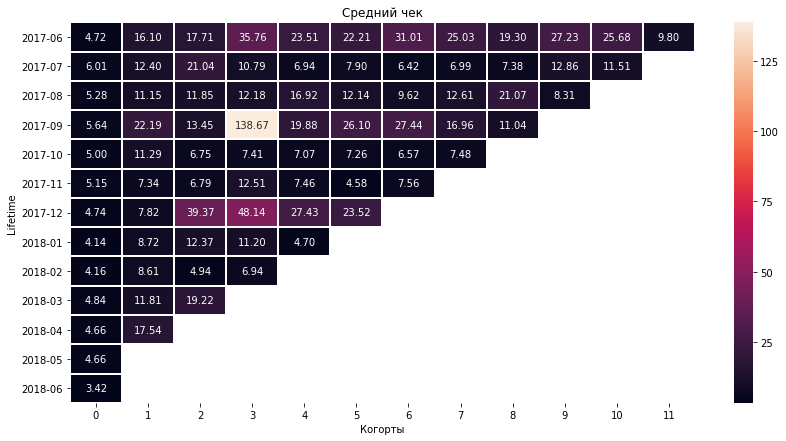

In [74]:
heatmap(mean_order_pivot,
       'Средний чек',
       'Когорты',
       'Lifetime')

Первое, что бросается в глаза - высокое значение среднего чека в четвертом месяце сентябрьской когорты - значение здесь составляет 138.67, что практически в 10 раз превышает этот же показатель за прошлый месяц и почти в 3 раза вторую по величине сумму, которую собрала декабрьская когорта на 4-м месяце жизни.  
Во всех когортах наблюдается увеличение среднего чека на втором месяце жизни. Чаще всего он возрастает примерно в 2 раза, однако в некоторых когортах (июньской, сентябрьской, апрельской) увеличение доходит до четырехкратного. С течением времени сумма внутри когорт также в целом увеличивается, однако сказывается сезонность предложения, и местами наблюдаются скачки этого показателя вниз.

Посмотрим на средний чек для всех пользователей без разбивки на когорты. Он будет равен среднему значению столбца с доходами таблицы `orders`:

In [75]:
orders['revenue'].mean()

4.999646930477041

В этом случае **средний чек покупателя составляет 5**.

Следующая метрика, которая нас интересует - это **LTV** (Lifetime Value). Она показывает итоговую сумма денег, которую один клиент приносит в среднем со всех своих покупок.  
Произведем подсчет данного показателя в трех измерениях:
1. Когорты
2. Тип рекламного источника
3. Устройство

В первом случае будем строить расчеты на основании таблицы `orders_cohorts`:

In [76]:
orders_cohorts.head()

,first_buy_month,buy_month,uid,revenue,revenue_per_user,lifetime
0,2017-06,2017-06-01,2023,9557.49,4.72,0
1,2017-06,2017-07-01,61,981.82,16.10,1
2,2017-06,2017-08-01,50,885.34,17.71,2
3,2017-06,2017-09-01,54,1931.30,35.76,3
4,2017-06,2017-10-01,88,2068.58,23.51,4


Для начала найдем начальное количество пользователей в каждой когорте. Оно будет равно максимальному значению столбца `uid` после группировки по первому месяцу покупки:

In [77]:
n_buyers = (orders_cohorts
            .groupby('first_buy_month')
            .agg({'uid':'max'})
            .reset_index()
            .rename(columns={'uid':'n_buyers'})
           )
n_buyers

,first_buy_month,n_buyers
0,2017-06,2023
1,2017-07,1923
2,2017-08,1370
3,2017-09,2581
4,2017-10,4340
5,2017-11,4081
6,2017-12,4383
7,2018-01,3373
8,2018-02,3651
9,2018-03,3533


Добавим начальное число пользователей в таблицу с когортами по первому месяцу покупки:

In [78]:
orders_cohorts = orders_cohorts.merge(n_buyers, on='first_buy_month')

**LTV** будет равняться отношению дохода к количеству покупателей. Добавим столбец с этими данными:

In [79]:
orders_cohorts['ltv'] = orders_cohorts['revenue'] / orders_cohorts['n_buyers']

In [80]:
orders_cohorts

,first_buy_month,buy_month,uid,revenue,revenue_per_user,lifetime,n_buyers,ltv
0,2017-06,2017-06-01,2023,9557.49,4.72,0,2023,4.72
1,2017-06,2017-07-01,61,981.82,16.10,1,2023,0.49
2,2017-06,2017-08-01,50,885.34,17.71,2,2023,0.44
3,2017-06,2017-09-01,54,1931.30,35.76,3,2023,0.95
4,2017-06,2017-10-01,88,2068.58,23.51,4,2023,1.02
...,...,...,...,...,...,...,...,...
74,2018-03,2018-05-01,58,1114.87,19.22,2,3533,0.32
75,2018-04,2018-04-01,2276,10600.69,4.66,0,2276,4.66
76,2018-04,2018-05-01,69,1209.92,17.54,1,2276,0.53
77,2018-05,2018-05-01,2988,13925.76,4.66,0,2988,4.66


Формируем сводную таблицу. Так же, как и ранее, в строках укажем когорты, в столбцах lifetime, значениями же будут показатели LTV в каждом месяце. После этого построим тепловую карту.

In [81]:
ltv_pivot = (orders_cohorts
         .pivot_table(index='first_buy_month', 
                      columns='lifetime', 
                      values='ltv', 
                      aggfunc='mean'))

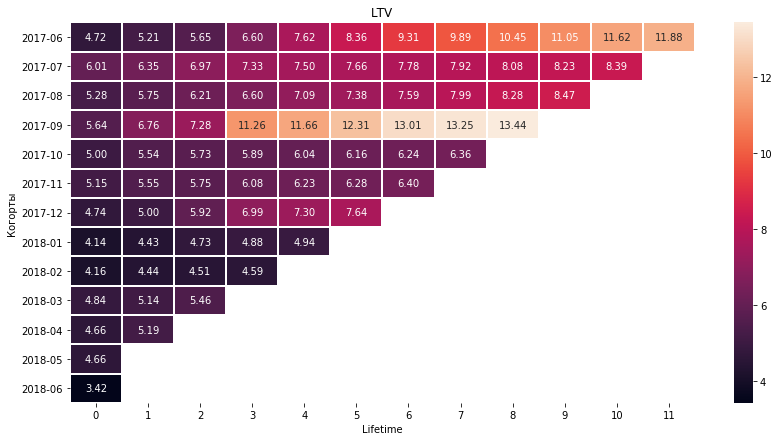

In [82]:
heatmap(ltv_pivot.cumsum(axis=1),
       'LTV',
       'Lifetime',
       'Когорты')

В среднем каждый пользователь приносит больше всего денег в первый месяц жизни своей когорты. После этого значения за редкими исключениями не превышают единицы. Здесь мы вновь можем наблюдать резкий скачок на четвертом месяце сентябрьской когорты - тогда сумма была ближе всего к начальной и составила почти 4.  
В первый месяц самый высокий показатель LTV в июльской когорте - тогда каждый клиент принес в среднем 6.

Посмотрим на распределение метрики по когортам.  
Для этого представим каждую когорту в виде столбца диаграммы с накоплением:

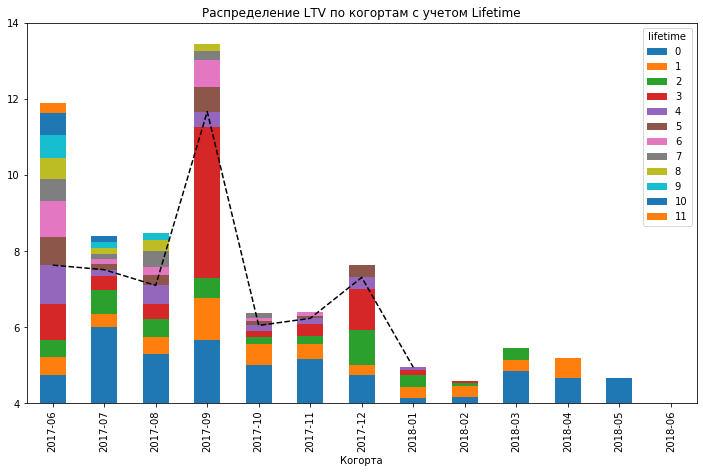

In [83]:
ax = ltv_pivot.cumsum(axis=1).reset_index()[4].plot(style='--', color='k')
ltv_pivot.plot(kind='bar', stacked=True, figsize=(12, 7), ax=ax)
plt.ylim(4, 14)
plt.title('Распределение LTV по когортам с учетом Lifetime')
plt.xlabel('Когорта')
plt.show()

На этом графике мы можем рассмотреть как изменялись показатели LTV и какая когорта показала лучший результат. Для этого сделаем своеобразный срез значений - в качестве примера будем рассматривать 4-й Lifetime (черная пунктирная линия на графике), так как до этого месяца дожили большинство из когорт. Здесь явным лидером является сентябрьская когорта - к обусловленному периоду ее пользователи принесли в полтора раза больше денег, чем вторая по этому показателю когорта июня 2017-го. К концу своей жизни эта же когорта в сумме показала лучший результат даже в сравнении с первой когортой, срок жизни которой больше на 3 месяца.

Теперь посчитаем эту же метрику в зависимости от **источника**. В данном случае показатель LTV будем рассматривать не только по покупателям, а по всем пользователям, заходившим на сайт, чтобы в дальнейшем сопоставить эти данные с расходами на каждый источник и подсчитать экономическую эффективность.  
Для решения этой задачи сформируем таблицу `users`, которая предствляет собой профиль пользователей. В ней для каждого пользователя будет отражены данные его **первого** визита: дата и время, источник перехода и устройство:

In [84]:
users = (visits.sort_values(by=['uid', 'start_ts']).groupby('uid')
.agg({'start_ts':'first', 'source_id':'first', 'device':'first'}) # указываем первое время посещения, первый источник и первое устройство
.rename(columns={'start_ts':'acquisition_ts'}))
users.head()

,acquisition_ts,source_id,device
uid,,,
11863502262781,2018-03-01 17:27:00,3,touch
49537067089222,2018-02-06 15:55:00,2,touch
297729379853735,2017-06-07 18:47:00,3,desktop
313578113262317,2017-09-18 22:49:00,2,desktop
325320750514679,2017-09-30 14:29:00,5,desktop


Добавим два столбца с датой и месяцем привлечения:

In [85]:
users['acquisition_date'] = users['acquisition_ts'].dt.date
users['acquisition_month'] = users['acquisition_date'].astype('datetime64[M]')
users.head()

,acquisition_ts,source_id,device,acquisition_date,acquisition_month
uid,,,,,
11863502262781,2018-03-01 17:27:00,3,touch,2018-03-01,2018-03-01
49537067089222,2018-02-06 15:55:00,2,touch,2018-02-06,2018-02-01
297729379853735,2017-06-07 18:47:00,3,desktop,2017-06-07,2017-06-01
313578113262317,2017-09-18 22:49:00,2,desktop,2017-09-18,2017-09-01
325320750514679,2017-09-30 14:29:00,5,desktop,2017-09-30,2017-09-01


Столбец `acquiaition_month` приведем к формату Год-Месяц:

In [86]:
users['acquisition_month'] = users['acquisition_month'].dt.strftime('%Y-%m')

Теперь подсчитаем доход с каждого пользователя и добавим его к профилю:

In [87]:
users_revenue = orders.groupby('uid').agg({'revenue':'sum'})
users_revenue.head()

,revenue
uid,
313578113262317,0.55
1575281904278712,3.05
2429014661409475,73.33
2464366381792757,2.44
2551852515556206,10.99


In [88]:
users = users.join(users_revenue, how='left').reset_index()
users.head()

,uid,acquisition_ts,source_id,device,acquisition_date,acquisition_month,revenue
0,11863502262781,2018-03-01 17:27:00,3,touch,2018-03-01,2018-03,nan
1,49537067089222,2018-02-06 15:55:00,2,touch,2018-02-06,2018-02,nan
2,297729379853735,2017-06-07 18:47:00,3,desktop,2017-06-07,2017-06,nan
3,313578113262317,2017-09-18 22:49:00,2,desktop,2017-09-18,2017-09,0.55
4,325320750514679,2017-09-30 14:29:00,5,desktop,2017-09-30,2017-09,nan


Для нахождения LTV осталось определить доход по месяцам для каждого источника и суммарное количество пользователей в каждом источнике:

In [89]:
ltv_source = users.groupby(['source_id', 'acquisition_month']).agg({'revenue':'sum'})
ltv_source.head()

revenue
source_id acquisition_month         
1         2017-06            9910.69
          2017-07            2341.21
          2017-08            2624.27
          2017-09            2414.97
          2017-10            3252.30

In [90]:
n_users_source = users.groupby('source_id').agg({'uid':'nunique'})
n_users_source

,uid
source_id,
1,9469
2,17616
3,66116
4,72346
5,49237
6,2
7,32
9,6448
10,6903


In [91]:
ltv_source = (ltv_source
              .join(n_users_source, how='left')
              .reset_index()
              .rename(columns={'uid':'n_users'})
             )
ltv_source.head()

,source_id,acquisition_month,revenue,n_users
0,1,2017-06,9910.69,9469
1,1,2017-07,2341.21,9469
2,1,2017-08,2624.27,9469
3,1,2017-09,2414.97,9469
4,1,2017-10,3252.30,9469


Метрика будет равна отношению дохода на количество пользователей:

In [92]:
ltv_source['ltv'] = ltv_source['revenue'] / ltv_source['n_users']
ltv_source.head()

,source_id,acquisition_month,revenue,n_users,ltv
0,1,2017-06,9910.69,9469,1.05
1,1,2017-07,2341.21,9469,0.25
2,1,2017-08,2624.27,9469,0.28
3,1,2017-09,2414.97,9469,0.26
4,1,2017-10,3252.30,9469,0.34


Построим сводную таблицу и визуализируем ее на тепловой карте:

In [93]:
ltv_source_pivot = (ltv_source
                    .pivot_table(index='source_id', 
                                 columns='acquisition_month', 
                                 values='ltv')
                    .cumsum(axis=1)
                    .fillna(0))

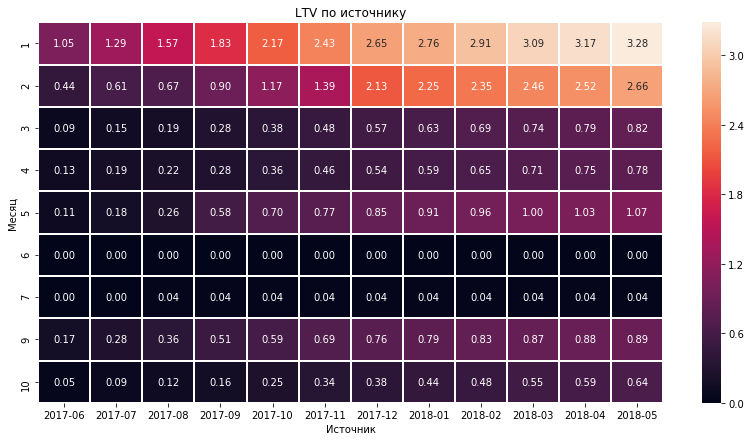

In [94]:
heatmap(ltv_source_pivot,
       'LTV по источнику',
       'Источник',
       'Месяц')

Наибольший LTV имеют пользователи, перешедшие по первому источнику - значения здесь выделяются как в первый, так и в последний месяц. Также хорошие показатели у источника 2, прибыль с него более чем в 2 раза превышает следующий по величине источник.  
Нулевая прибыль от 6 источника говорит нам о его неэффективности - это значение сохраняется на протяжении всего исследуемого периода. Помимо него низкие показатели имеет источник номер 7 - прибыль от него появилась только в одном месяце.  
Посмотрим на распределение LTV  на графике:

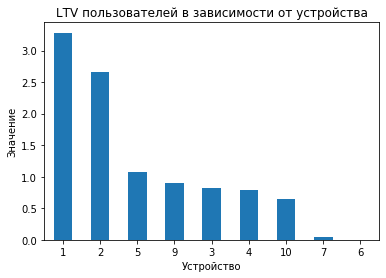

In [95]:
(ltv_source_pivot
 .reset_index()
 .set_index('source_id')['2018-05']
 .sort_values(ascending=False)
 .plot(kind='bar'))
plt.title('LTV пользователей в зависимости от устройства')
plt.xlabel('Устройство')
plt.ylabel('Значение')
plt.xticks(rotation=0)
plt.show()

Источники 9, 3, 4 и 10 имеют практически одинаковые значения и во всех они меньше единицы, источник 5 немного эту йифру превосходит. 

Проделаем те же самые действия с разбивкой на **устройства**. В нашем случае их 2 - ПК и мобильные.

In [96]:
ltv_device = users.groupby(['device', 'acquisition_month']).agg({'revenue':'sum'})
ltv_device.head()

revenue
device  acquisition_month         
desktop 2017-06           35403.63
        2017-07           14083.05
        2017-08           10361.93
        2017-09           29243.29
        2017-10           22885.48

In [97]:
n_users_device = users.groupby('device').agg({'uid':'nunique'})
n_users_device

,uid
device,
desktop,160795
touch,67374


In [98]:
ltv_device = (ltv_device
              .join(n_users_device, how='left')
              .reset_index()
              .rename(columns=({'uid':'n_users'}))
             )
ltv_device.head()

,device,acquisition_month,revenue,n_users
0,desktop,2017-06,35403.63,160795
1,desktop,2017-07,14083.05,160795
2,desktop,2017-08,10361.93,160795
3,desktop,2017-09,29243.29,160795
4,desktop,2017-10,22885.48,160795


In [99]:
ltv_device['ltv'] = ltv_device['revenue'] / ltv_device['n_users']
ltv_device.head()

,device,acquisition_month,revenue,n_users,ltv
0,desktop,2017-06,35403.63,160795,0.22
1,desktop,2017-07,14083.05,160795,0.09
2,desktop,2017-08,10361.93,160795,0.06
3,desktop,2017-09,29243.29,160795,0.18
4,desktop,2017-10,22885.48,160795,0.14


In [100]:
ltv_device_pivot = (ltv_device
                    .pivot_table(index='device',
                                 columns='acquisition_month',
                                 values='ltv')
                    .cumsum(axis=1))                   

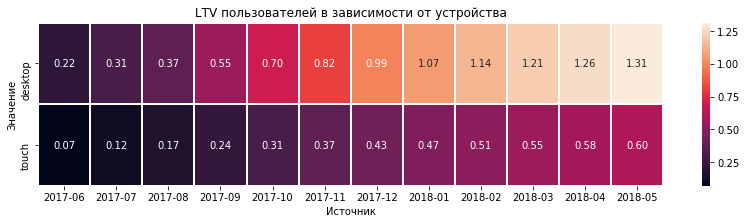

In [101]:
heatmap(ltv_device_pivot,
       'LTV пользователей в зависимости от устройства',
       'Источник',
       'Значение',
       3)

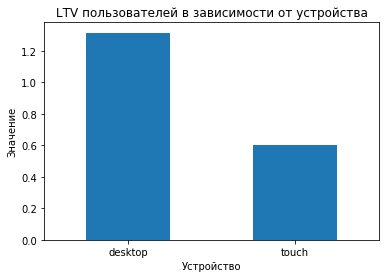

In [102]:
ltv_device_pivot.reset_index().set_index('device')['2018-05'].plot(kind='bar')
plt.title('LTV пользователей в зависимости от устройства')
plt.xlabel('Устройство')
plt.ylabel('Значение')
plt.xticks(rotation=0)
plt.show()

LTV пользователей, посещающих сайт со стационарных платформ значительно выше этого показателя с мобильных - разница здесь более чем в 2 раза. 

Таким образом, на основе анализа таблицы с покупками, мы можем сделать **следующие выводы**:
1. Большинство пользователей совершают первую покупку уже спустя минуту после захода на сайт.
2. Пользователи чаще всего совершают только одну покупку за весь период. Среднее количество заказов в месяц - 3878, в неделю - 951.
3. Во всех когортах наблюдается увеличение среднего чека на втором месяце жизни, максимальное значение этого показателя достигает 138,67.
4. Средний чек кажой покупки равен 5.
5. В среднем каждый пользователь приносит больше всего денег в первый месяц жизни своей когорты
5. Наибольший LTV имеют пользователи, перешедшие по первому источнику. Нулевые значения показывает источник номер 6.
6. LTV пользователей ПК более чем в 2 раза превышает этот показатель мобильных платформ.

### Маркетинг <a id='costs'></a>
[Назад к оглавлению](#content)

На данном эта пе мы изучим таблицу с затратами на маркетинг и вычислим, сколько денег было затрачено: всего, на каждый источник и по времени. После этого узнаем сколько стоило привлечение одного покупателя из каждого источника, а также насколько окупились расходы.

Определим **общую сумму затрат на маркетинг**:

In [103]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [104]:
total_costs = costs['costs'].sum()
total_costs

329131.62

**За год на маркетинг было израсходовано 329131,62**.

Найдем сумму расходов по каждому **источнику**:

In [105]:
costs_by_source = costs.groupby('source_id')['costs'].sum().reset_index()
costs_by_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


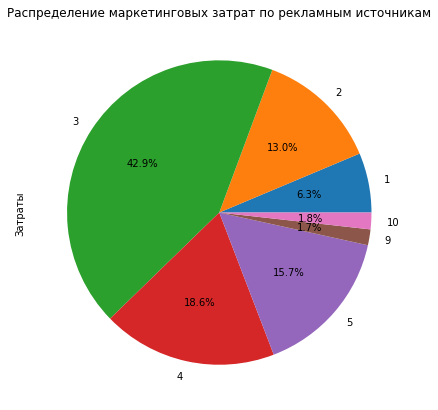

In [106]:
costs_by_source.set_index('source_id')['costs'].plot(kind='pie', figsize=(7,7), autopct='%1.1f%%')
plt.title('Распределение маркетинговых затрат по рекламным источникам')
plt.ylabel('Затраты')
plt.show()

Почти половина всех затрат пришлась на источник 3 - 43%, что в денежном эквиваленте составляет 141321,63. На все остальные они не превышали 20%, наибольшие значения имеют 4, 5 и 2 источники.

Рассмотрим распределение маркетинговых затрат **по месяцам**:

In [107]:
costs['dt_month'] = costs['dt'].astype('datetime64[M]').dt.strftime('%Y-%m')
costs.head()

,source_id,dt,costs,dt_month
0,1,2017-06-01,75.20,2017-06
1,1,2017-06-02,62.25,2017-06
2,1,2017-06-03,36.53,2017-06
3,1,2017-06-04,55.00,2017-06
4,1,2017-06-05,57.08,2017-06


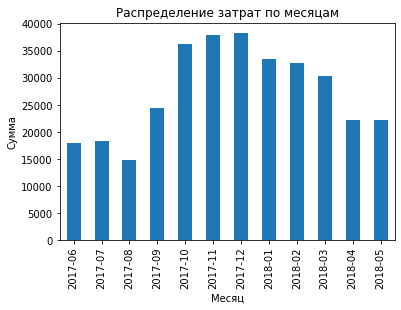

In [108]:
costs.groupby('dt_month')['costs'].sum().plot(kind='bar')
plt.title('Распределение затрат по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Сумма')
plt.show()

Распредление месячных затрат похоже на распределение покупок, описанных выше: наибольшая сумма приходится с октября по март, пиковое значение достигается к концу года. Меньше всего компания тратила на маркетинг в августе - менее 15000.

Построим распределение расходов по месяцам в разрезе источников:

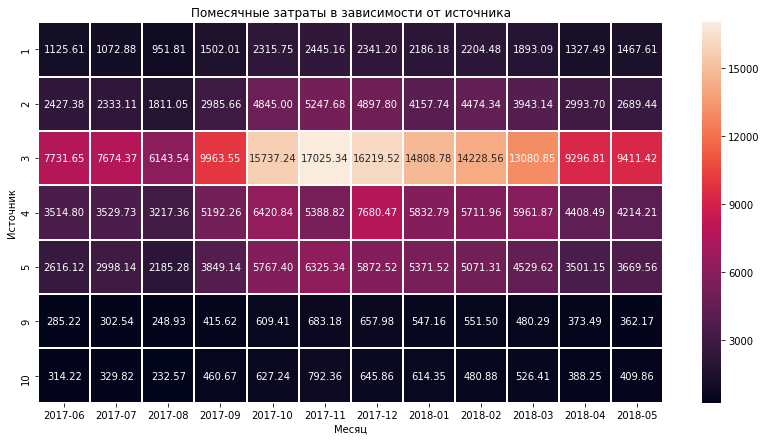

In [109]:
costs_pivot = (costs
               .pivot_table(index='source_id', 
                            columns='dt_month', 
                            values='costs', 
                            aggfunc='sum'))
heatmap(costs_pivot,
       'Помесячные затраты в зависимости от источника',
       'Месяц',
       'Источник')

Если рассмотреть изменения помесячных расходов в разрезе истоников, то здесь так же выделяются значения источника номер 3. Максимальные значения достиглись в ноябре, тогда было потрачено 17025, разница с минимальной августовской суммой здесь является практически троекратной. Увеличение суммы расходов в осенне-зимние месяцы являются характерными для всех источников, но изменения уже не такие сильные, разница с затратами летом практически везде приблизительно в 2 раза. Здесь мы также можем наблюдать низкие затраты на источники 9 и 10 - максимальные суммы здесь также в ноябре - 683 и 792 соответственно.

Теперь узнаем сколько стоило **привлечение одного покупателя** из каждого источника.  
Для этого нам понадобится метрика **CAC**, которая представляет собой сумму затрат, деленную на количество покупателей.  
Вновь обратимся к профилю пользователей:

In [110]:
users.head()

,uid,acquisition_ts,source_id,device,acquisition_date,acquisition_month,revenue
0,11863502262781,2018-03-01 17:27:00,3,touch,2018-03-01,2018-03,nan
1,49537067089222,2018-02-06 15:55:00,2,touch,2018-02-06,2018-02,nan
2,297729379853735,2017-06-07 18:47:00,3,desktop,2017-06-07,2017-06,nan
3,313578113262317,2017-09-18 22:49:00,2,desktop,2017-09-18,2017-09,0.55
4,325320750514679,2017-09-30 14:29:00,5,desktop,2017-09-30,2017-09,nan


День затраты определенной суммы на маркетинг в таблице `costs` будет соответствовать дню привлечения клиента. Соединим обе эти таблицы по id пользователя и дню привлечения:

In [111]:
costs = costs.rename(columns={'dt':'acquisition_date'})

In [112]:
users = (users.set_index(['source_id', 'acquisition_date'])
.join(costs.set_index(['source_id', 'acquisition_date']), how = 'left'))
users.head()

uid      acquisition_ts   device  \
source_id acquisition_date                                                     
1         2017-06-01         469568501030474895 2017-06-01 05:30:00  desktop   
          2017-06-01         618675438905551322 2017-06-01 02:37:00    touch   
          2017-06-01        1074355127080856382 2017-06-01 09:21:00  desktop   
          2017-06-01        1292867924428534308 2017-06-01 12:53:00  desktop   
          2017-06-01        1548840741623289234 2017-06-01 01:18:00  desktop   

                           acquisition_month  revenue  costs dt_month  
source_id acquisition_date                                             
1         2017-06-01                 2017-06    70.69  75.20  2017-06  
          2017-06-01                 2017-06      nan  75.20  2017-06  
          2017-06-01                 2017-06     0.37  75.20  2017-06  
          2017-06-01                 2017-06     4.28  75.20  2017-06  
          2017-06-01                 2017-06      nan  75.20  2017-06

Определим сколько в среднем стоило привлечение одного пользователя каждый день. Для этого сгруппируем таблицу по источнику и дате привлечения, посчитаем сколько новых посетителей заходило на сайт каждый день и разделим их на сумму маркетинговых затрат за эту дату:

In [113]:
user_cost = (users.groupby(['source_id', 'acquisition_date'])
             .agg({'device':'count', 'costs':'max'})
             .rename(columns={'device':'users'})
            )
user_cost.head()

users  costs
source_id acquisition_date              
1         2017-06-01           47  75.20
          2017-06-02           27  62.25
          2017-06-03           22  36.53
          2017-06-04           23  55.00
          2017-06-05           39  57.08

In [114]:
user_cost['acquisition_cost'] = user_cost['costs'] / user_cost['users']
user_cost.head()

users  costs  acquisition_cost
source_id acquisition_date                                
1         2017-06-01           47  75.20              1.60
          2017-06-02           27  62.25              2.31
          2017-06-03           22  36.53              1.66
          2017-06-04           23  55.00              2.39
          2017-06-05           39  57.08              1.46

Присоединим стоимость пользователя к его профилю:

In [115]:
users = (users
         .join(user_cost[['acquisition_cost']], 
               how='left')
         .reset_index()
         .drop('dt_month', axis=1))
users.head()

,source_id,acquisition_date,uid,acquisition_ts,device,acquisition_month,revenue,costs,acquisition_cost
0,1,2017-06-01,469568501030474895,2017-06-01 05:30:00,desktop,2017-06,70.69,75.20,1.60
1,1,2017-06-01,618675438905551322,2017-06-01 02:37:00,touch,2017-06,nan,75.20,1.60
2,1,2017-06-01,1074355127080856382,2017-06-01 09:21:00,desktop,2017-06,0.37,75.20,1.60
3,1,2017-06-01,1292867924428534308,2017-06-01 12:53:00,desktop,2017-06,4.28,75.20,1.60
4,1,2017-06-01,1548840741623289234,2017-06-01 01:18:00,desktop,2017-06,nan,75.20,1.60


Теперь среди всех пользователей выделим только тех, кто совершал покупки:

In [116]:
customers = users[~users['revenue'].isna()]
customers.head()

,source_id,acquisition_date,uid,acquisition_ts,device,acquisition_month,revenue,costs,acquisition_cost
0,1,2017-06-01,469568501030474895,2017-06-01 05:30:00,desktop,2017-06,70.69,75.20,1.60
2,1,2017-06-01,1074355127080856382,2017-06-01 09:21:00,desktop,2017-06,0.37,75.20,1.60
3,1,2017-06-01,1292867924428534308,2017-06-01 12:53:00,desktop,2017-06,4.28,75.20,1.60
5,1,2017-06-01,2050423809815667474,2017-06-01 10:36:00,desktop,2017-06,8.31,75.20,1.60
6,1,2017-06-01,3520273333047097992,2017-06-01 20:08:00,desktop,2017-06,0.24,75.20,1.60


Чтобы вычислить **CAC по источнику**, найдем количество покупателей из этого источника и разделим на него сумму затрат на покупателей из этого источника:

In [117]:
cac_source = (customers.groupby('source_id')
              .agg({'uid':'nunique', 
                    'acquisition_cost':'sum'})
              .reset_index()
              .rename(columns=({'uid':'n_customers'}))
             )
cac_source

,source_id,n_customers,acquisition_cost
0,1,2899,6223.39
1,2,3506,8221.79
2,3,10473,22139.71
3,4,10296,8783.89
4,5,6931,7275.39
5,7,1,0.00
6,9,1088,906.64
7,10,1329,1125.18


In [118]:
cac_source['cac'] = cac_source['acquisition_cost'] / cac_source['n_customers']
cac_source

,source_id,n_customers,acquisition_cost,cac
0,1,2899,6223.39,2.15
1,2,3506,8221.79,2.35
2,3,10473,22139.71,2.11
3,4,10296,8783.89,0.85
4,5,6931,7275.39,1.05
5,7,1,0.00,0.00
6,9,1088,906.64,0.83
7,10,1329,1125.18,0.85


Потому же принципе вычислим **CAC для устройств**:

In [119]:
cac_device = (customers.groupby('device')
              .agg({'uid':'nunique', 
                    'acquisition_cost':'sum'})
              .reset_index()
              .rename(columns=({'uid':'n_customers'})))
cac_device

,device,n_customers,acquisition_cost
0,desktop,29211,43840.65
1,touch,7312,10835.34


In [120]:
cac_device['cac'] = cac_device['acquisition_cost'] / cac_device['n_customers']
cac_device

,device,n_customers,acquisition_cost,cac
0,desktop,29211,43840.65,1.50
1,touch,7312,10835.34,1.48


Представим значения в итоговой таблице:

|Источник|CAC|Устройство|CAC|
|---|---|---|---|
|1|2.13|desktop|1.50|
|2|2.35|touch|1.48|
|3|2.11|
|4|0.85|
|5|1.05|
|7|0|
|9|0.83|
|10|0.85|

Наибольшую среднюю стоимость привлечения показывает источник 2 - 2.35. Близкие к нему значения имеют 1-й и 3-й источники - 2.13 и 2.11 соответственно. CAC для семерки равен 0 - затрат на привлечение пользователей из него не осуществлялось. Также отсутствуют данные для источника 6, так как те несколько пользователей, которые впервые перешли по нему на лендинг, покупок не совершали. Минимальную стоимость показывают сразу три источника - 4, 9 и 10: стоимость одного покупателя составила 0,83-0,85.  
Метрика для покупателей в разрезе устройств оказалась примерно равная, с небольшим преимуществом сенсорных устройств: для desktop значение составляет 1,5, для вторых - 1.48.

Теперь узнаем как менялись показатели **САС каждый месяц в разрезе источников и устройств**. Для этого проделаем те же операции, что и при вычислении среднего САС, но группировать таблицу `customers` будем не только по исследуемым параметрам, но и по месяцам привлечения. В результате получим сводную таблицу, благодаря которой можем проанализировать динамику изменений интересующей нас метрики. 

In [121]:
cac_source_by_month = (customers.groupby(['source_id', 'acquisition_month'])
.agg({'uid':'count', 
      'acquisition_cost':'sum'})
.reset_index())
cac_source_by_month['cac'] = cac_source_by_month['acquisition_cost'] / cac_source_by_month['uid']
cac_source_pivot = (cac_source_by_month
                    .pivot_table(index='source_id', 
                                 columns='acquisition_month', 
                                 values='cac')
                    .fillna(0))

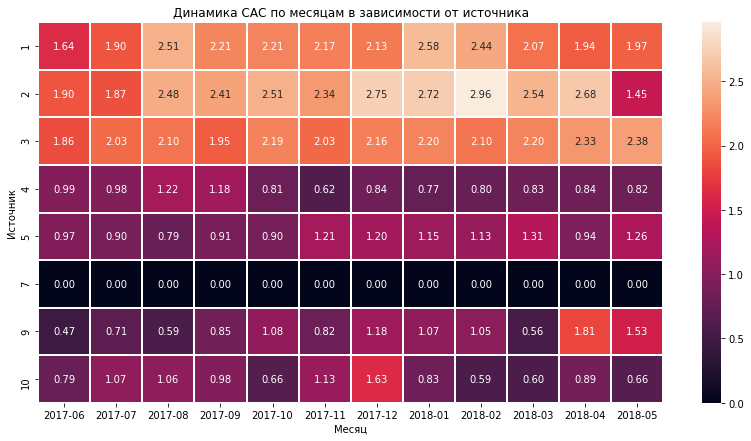

In [122]:
heatmap(cac_source_pivot,
       'Динамика САС по месяцам в зависимости от источника',
       'Месяц',
       'Источник')

Наибольшее колебание значений показывает источник 2: здесь минимальная стоимость привлечения покупателя была на последнем месяце исследовательского периода - в мае 2018 - и равнялась 1.45, а самое высокое же значение (как для этого источника, так и для всех остальных) было за 3 месяца до этого, в феврале - тогда каждый клиент обходился в 2.96. Достаточно высокие, но более стабильные цифры показывают 1 и 3 источники: на протяжении года стоимость одного клиента колеблется в районе 2. Изменения происходят неравномерно, явной зависимости от месяца не наблюдается. Таким образом привлечение покупателей по источникам 1, 2 и 3 является для компании наименее выгодным.  
Остальные источники так же не показывают явной динамики в течении года. Для 4-ки и 5-ки максимальные значения находятся в районе 1.25 - они уже меньше, чем минимальные значения источников 1-3. Еще более низкие показатели для 9 и 10 источников однако здесь мы наблюдаем несколько скачков, где цена возрастала довольно существенно: для 9-ки они происходили в 2 последних наблюдаемых месяцах и достигли 1.81 и 1.53, а для 10-ки один такой скачок был зафиксирован в декабре - тогда один покупатель стоил 1.63.

Рассмотрим такую же динамику для устройств:

In [123]:
cac_device_by_month = (customers.groupby(['device', 'acquisition_month'])
.agg({'uid':'count', 
      'acquisition_cost':'sum'})
.reset_index())
cac_device_by_month['cac'] = cac_device_by_month['acquisition_cost'] / cac_device_by_month['uid']
cac_device_pivot = (cac_device_by_month
                    .pivot_table(index='device', 
                                 columns='acquisition_month', 
                                 values='cac')
                    .fillna(0))

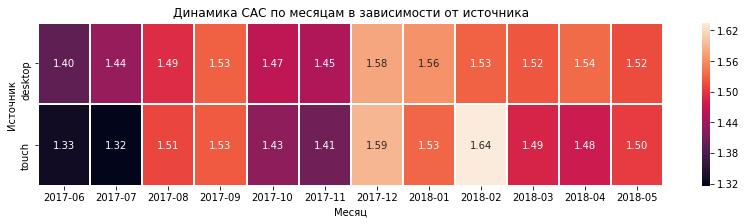

In [124]:
heatmap(cac_device_pivot,
       'Динамика САС по месяцам в зависимости от источника',
       'Месяц',
       'Источник',
       3)

Несмотря на то, что средние показатели САС для обоих устройств оказались почти одинаковыми, в динамике мы видим небольшое преимущество для touch. Первые два месяца здесь стоимость была минимальной - 1.33, обратный скачок произошел в феврале - стоимость достигла 1.64. Тем не менее практически в каждом месяце мы можем видеть, что стоимость привлечения с мобильных устройств либо примерно равна, либо меньше, чем этот показатель для desktop.

Последнее, что нужно определить - это **насколько окупились маркетинговые расходы** в зависимости от источника и устройства.  
За это отвечает метрика **ROMI**. Она представляет собой отношение LTV к CAC.  
К таблице, в которой мы группировали пользователей по источникам перехода и считали LTV, добавим показатели CAC для этого источника. Запишем полученные данные в новую таблицу:

In [125]:
ltv_source.head()

,source_id,acquisition_month,revenue,n_users,ltv
0,1,2017-06,9910.69,9469,1.05
1,1,2017-07,2341.21,9469,0.25
2,1,2017-08,2624.27,9469,0.28
3,1,2017-09,2414.97,9469,0.26
4,1,2017-10,3252.30,9469,0.34


In [126]:
romi_source = (ltv_source[['source_id', 'acquisition_month', 'ltv']]
                 .merge(cac_source[['source_id', 'cac']], 
                        on='source_id', 
                        how='left'))
romi_source.head()

,source_id,acquisition_month,ltv,cac
0,1,2017-06,1.05,2.15
1,1,2017-07,0.25,2.15
2,1,2017-08,0.28,2.15
3,1,2017-09,0.26,2.15
4,1,2017-10,0.34,2.15


Найдем ROMI, поделив столбец c LTV  на столбец CAC:

In [127]:
romi_source['romi'] = romi_source['ltv'] / romi_source['cac']
romi_source.head()

,source_id,acquisition_month,ltv,cac,romi
0,1,2017-06,1.05,2.15,0.49
1,1,2017-07,0.25,2.15,0.12
2,1,2017-08,0.28,2.15,0.13
3,1,2017-09,0.26,2.15,0.12
4,1,2017-10,0.34,2.15,0.16


Рассчитаем накопительный ROMI для каждого источника и вновь обратимся к тепловой карте:

In [128]:
romi_source_pivot = (romi_source
                     .pivot_table(index='source_id', 
                                  columns='acquisition_month', 
                                  values='romi')
                     .cumsum(axis=1)
                     .fillna(0)
                     .query('source_id != 7'))
romi_source_pivot

acquisition_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
source_id,,,,,,,,,,,,
1,0.49,0.60,0.73,0.85,1.01,1.13,1.23,1.28,1.36,1.44,1.48,1.53
2,0.19,0.26,0.29,0.38,0.50,0.59,0.91,0.96,1.00,1.05,1.08,1.14
3,0.04,0.07,0.09,0.13,0.18,0.23,0.27,0.30,0.33,0.35,0.37,0.39
4,0.16,0.22,0.26,0.32,0.43,0.54,0.63,0.70,0.76,0.83,0.88,0.92
5,0.10,0.17,0.25,0.55,0.67,0.73,0.81,0.86,0.92,0.95,0.99,1.02
9,0.21,0.33,0.44,0.61,0.71,0.83,0.91,0.95,0.99,1.04,1.06,1.07
10,0.06,0.10,0.14,0.19,0.29,0.41,0.45,0.52,0.56,0.65,0.70,0.76


Наилучшую окупаемость показал источник номер 1, расходы на него окупились на 5-м месяце. Следующий источник, чей показатель ROMI превысил единицу - номер 2, случилось это на 9-м месяце. В этом же месяце почти окупились расходы с 9-го источника - значение 0.99. Худшую окупаемость демонстрирует источник 3, за год показатель ROMI достиг только 40%.

Посмотрим на среднее значение окупаемости:

In [129]:
romi_source_pivot.mean()

acquisition_month
2017-06   0.18
2017-07   0.25
2017-08   0.31
2017-09   0.44
2017-10   0.54
2017-11   0.64
2017-12   0.74
2018-01   0.79
2018-02   0.85
2018-03   0.90
2018-04   0.94
2018-05   0.98
dtype: float64

Здесь значения под конец года близки к показателю окупаемости, но не дотягивают до него двух процентов. Судя по динамике, начиная с 13 месяца расходы в среднем начнут окупаться.

Также визуализируем изменения ROMI по месяцам на графике. Обозначим пунктирной линией порог окупаемости - как только график ее пересечет, значит, что затраты на этот источник окупились. Процесс построения графика запишем в функцию:

In [130]:
def romi_plot(data, title):
    fig, ax = plt.subplots()
    x = data.T
    ax.plot(x)
    plt.style='-o'
    ax.hlines(1, 0, 11, linestyle = '--')
    fig.set_figwidth(12)
    fig.set_figheight(6)
    ax.legend(x)
    plt.title(title)
    plt.xlabel('Месяц')
    plt.ylabel('ROMI')
    plt.show()

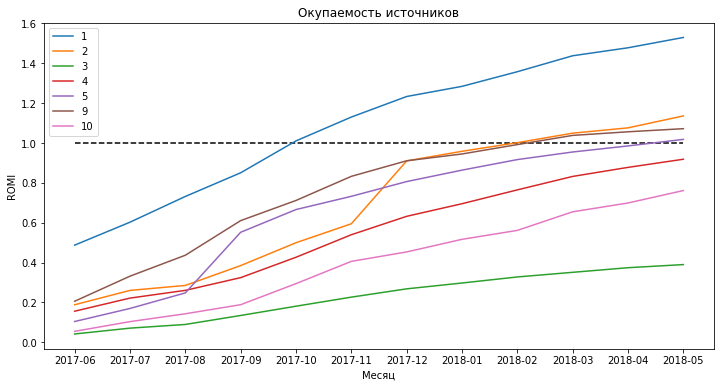

In [131]:
romi_plot(romi_source_pivot, 'Окупаемость источников')

Здесь мы наглядно видим, что в конечном счете 4 из 7 источников пересекли порог, причем источник 5 сделал это в последний месяц. Окупаемость первого источника заметно выделяется уже начиная с первого месяца. Источник 3 оставался последним по окупаемости на протяжении всего периода исследования.

Теперь так же рассмотрим окупаемость устройств:

In [132]:
ltv_device.head()
romi_device = (ltv_device[['device', 
                           'acquisition_month', 
                           'ltv']]
               .merge(cac_device[['device', 'cac']], 
                      on='device', 
                      how='left'))
romi_device['romi'] = romi_device['ltv'] / romi_device['cac']

In [133]:
romi_device_pivot = (romi_device
                     .pivot_table(index='device', 
                                  columns='acquisition_month', 
                                  values='romi')
                     .cumsum(axis=1))
romi_device_pivot

acquisition_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
device,,,,,,,,,,,,
desktop,0.15,0.21,0.25,0.37,0.46,0.55,0.66,0.71,0.76,0.81,0.84,0.88
touch,0.05,0.08,0.11,0.16,0.21,0.25,0.29,0.32,0.34,0.37,0.39,0.41


Среднее значение метрики:

In [134]:
romi_device_pivot.mean()

acquisition_month
2017-06   0.10
2017-07   0.14
2017-08   0.18
2017-09   0.26
2017-10   0.34
2017-11   0.40
2017-12   0.48
2018-01   0.51
2018-02   0.55
2018-03   0.59
2018-04   0.61
2018-05   0.64
dtype: float64

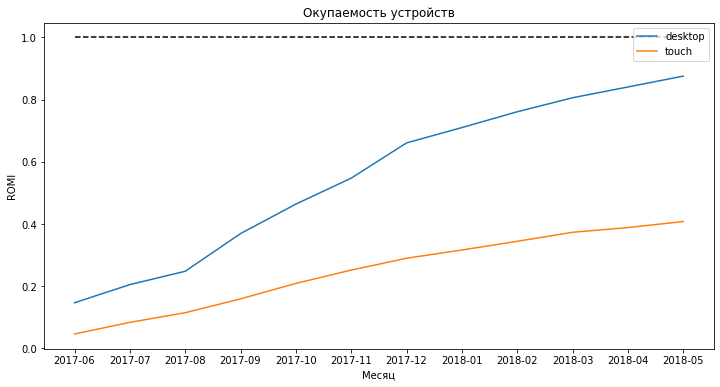

In [135]:
romi_plot(romi_device_pivot, 'Окупаемость устройств')

На данный момент ни стационарные, ни мобильные устройства полностью не окупились. Среднее значение окупаемости к концу года составило 64%. При этом desktop показывает более убедительную динамику, на конец исследуемого периода затраты на него окупились практически на 90%, в то время как показатель ROMI для touch остановился на отметке 41%.  
Таким образом desktop является более предпочтительным.

## 3. Вывод и рекомендации <a id='conclusion'></a>
[Назад к оглавлению](#content)

Таким образом мы завершили наше исследование пользовательской активности сервиса Яндекс.Афиша, покупок, совершенных пользователями, а также маркетинговых затрат. Мы подсчитали все необходимые метрики, которые позволили проанализировать эффективность сервиса и дали возможность оптимизировать затраты на маркетинг для его повышения.

На первом этапе исследований мы вычислили метрики, относящиеся к активности пользователей: количество уникальных пользователей в день (**DAU**), неделю (**WAU**) и месяц (**MAU**). Результаты оказались следующими:
1. DAU - 907 человек.
2. WAU - 5716 человек.
3. MAU - 23228 человека.  

Среднее количество сессий в день равняется 987, а большая часть из них имеет продолжительность в одну минуту (метрика **ASL**). Здесь показатель продолжительности выбирался исходя из моды, так как распределение длительности сессий не имело нормальный вид и использовать среднее значение или медиану было бы некорректно.   
Чтобы определить как часто люди возвращаются на сайт, мы подсчитали метрику **Retension Rate** (коэффициент удержания). Для этого мы разделили всех пользователей по когортам - одна когорта включала в себя пользователей, которые впервые зашли на сайт в определенный месяц года. По полученным данным мы наблюдали тенденцию к снижению значения метрики по когортам, в среднем количество пользователей на второй месяц "жизни" когорты снижалась в 10-15 раз. К концу исследуемого периода во всех когортах кроме первой процент пользователей не превышает 3 от изначального числа. Низкие показатели говорят нам о том, что юзеры, как правило, пользуются сервисом единожды.  

При анализе покупок, совершенных пользователями мы определили сколько времени проходит с момента первого посещения сайта до первой покупки. Медианное значение равнялось 16 минутам, среднее во много раз превышало его, однаком, как и с вслучае с продолжительностью сессий, распределение не имело нормального характера и значение моды показало, что уже через минуту после первого визита пользователь что-то приобретает.  
Каждый пользователь чаще всего совершает только одну покупку за весь исследуемый период. **Среднее количество заказов** в месяц составило 3878, в неделю этот показатель был равен 951. Было отмечено повышение спроса в осенние и зимние месяцы, наибольшее значение (около 6000 покупок) было зафиксировано в декабре. С октябра по март значения так же достаточно высоки и варьируются в районе 5000.  
**Средний чек** покупателей для каждой когорты показывал увеличение на втором месяце жизни. Чаще всего он возрастает примерно в 2 раза, однако в некоторых когортах (июньской, сентябрьской, апрельской) увеличение доходит до четырехкратного. С течением времени сумма внутри когорт также в целом увеличивается, однако сказывается сезонность предложения, и местами наблюдаются скачки этого показателя вниз. В целом среднее значение одной покупки без разделения пользователей на когорты равняется 5-и.  
Итоговую сумму денег, которую один клиент приносит в среднем со всех своих покупок показала метрика Lifetime Value (**LTV**). Для каждой месячной когорты этот показатель был максимальным в первый месяц. В последующие же, за редким исключением, сумма была в разы меньше. Для определения лучшего показателя LTV в динамике, мы выделили срез - посмотрели, каковы значения метрики на 4-м lifetime в каждой когорте (так как до этого времени "дожили" большинство когорт). В результате к этому сроку лучший результат показала сентябрьская когорта - ее пользователи принесли в полтора раза больше денег, чем вторая по этому показателю когорта июня 2017-го. К концу своей жизни эта же когорта в сумме показала лучший результат даже в сравнении с первой когортой, срок жизни которой больше на 3 месяца.  
Для вычисления LTV в зависимости от источника перехода мы учитывали всех пользователей независимо от того, совершали ли они покупки или нет,  чтобы в дальнейшем произвести расчет экономической эффективности, используя эту метрику. Наибольший LTV имеют пользователи, перешедшие по первому источнику - значения здесь выделяются как в первый, так и в последний месяц. Также хорошие показатели у источника 2, прибыль с него почти в 2 раза превышает следующий по величине источник. Нулевая прибыль от 6 источника говорит нам о его неэффективности - это значение сохраняется на протяжении всего исследуемого периода. Помимо него низкие показатели имеет источник номер 7 - прибыль от него появилась только в одном месяце.  
При расчете LTV в зависимости от используемого устройства, мы выявили, что эта метрика для пользователей, посещающих сайт со стационарных платформ значительно выше, чем с мобильных - разница здесь более чем в 2 раза.  

При анализе затарат мы определили следующее:
1. Всего на маркетинг было израсходовано 329131,62 за исследуемый период.
2. Почти половина всех затрат пришлась на источник 3 - 43%, что в денежном эквиваленте составляет 141321,63. На все остальные они не превышали 20%, наибольшие значения имеют 4, 5 и 2 источники.
3. Распредление месячных затрат похоже на распределение покупок: наибольшая сумма приходится с октября по март, пиковое значение достигается к концу года. Меньше всего компания тратила на маркетинг в августе - менее 15000.  
Если рассмотреть изменения помесячных расходов в разрезе истоников, то здесь так же выделяются значения источника номер 3. Максимальные значения достиглись в ноябре, тогда было потрачено 17025, разница с минимальной августовской суммой здесь является практически троекратной. Увеличение суммы расходов в осенне-зимние месяцы являются характерными для всех источников, но изменения уже не такие сильные, разница с затратами летом практически везде приблизительно в 2 раза. Здесь мы также можем наблюдать низкие затраты на источники 9 и 10 - максимальные суммы у них также в ноябре - 683 и 792 соответственно.

Стоимость привлечения одного покупателя из каждого источника определила метрика **CAC**.Здесь выделились 3 источника с наибольшими затратами на привлечение одного пользователя: номер 2 показывает наибольшее значение, стоимость составляет 2,35. Также значения, превышеющие 2, имеют источники с номерами 1 и 3. Около единицы показатели CAC у источников 5, 9, 4 и 10. Для 6 и 7 значения нулевые. Метрика для покупателей в разрезе устройств оказалась примерно равная, с небольшим преимуществом сенсорных устройств: для desktop значение составляет 1,5, для вторых - 1.48.  
В динамике по месяцам наибольшее колебание значений показывает источник 2: здесь минимальная стоимость привлечения покупателя была на последнем месяце исследовательского периода - в мае 2018 - и равнялась 1.45, а самое высокое же значение (как для этого источника, так и для всех остальных) было за 3 месяца до этого, в феврале - тогда каждый клиент обходился в 2.96. Достаточно высокие, но более стабильные цифры показывают 1 и 3 источники: на протяжении года стоимость одного клиента колеблется в районе 2. Изменения происходят неравномерно, явной зависимости от месяца не наблюдается. Таким образом привлечение покупателей по источникам 1, 2 и 3 является для компании наименее выгодным. Остальные источники так же не показывают явной динамики в течении года.   
Несмотря на то, что средние показатели САС для обоих устройств оказались почти одинаковыми, в динамике мы видим небольшое преимущество для touch. Первые два месяца здесь стоимость была минимальной - 1.33, обратный скачок произошел в феврале - стоимость достигла 1.64. Тем не менее практически в каждом месяце мы можем видеть, что стоимость привлечения с мобильных устройств либо примерно равна, либо меньше, чем этот показатель для desktop.  
Окупаемость маркетинговых затрат по источнику и устройству показывает **ROMI**, которая представляет собой отношение LTV к CAC.   
Наилучшую окупаемость показал источник номер 1, расходы на него окупились на 5-м месяце. Следующий источник, чей показатель ROMI превысил единицу - номер 2, случилось это на 9-м месяце. В этом же месяце почти окупились расходы с 9-го источника - значение 0.99. Худшую окупаемость демонстрирует источник 3, за год показатель ROMI достиг только 40%. Средняя окупаемость спустя год только близится к единице.  
В зависимости от устройства лучшую окупаемость показывает desktop, однако на конец исследуемого периода окупаемость еще не наступила - значение достигло почти 90%. Затраты на устройства touch не окупились чуть больше, чем на треть. Среднее значение окупаемости устройств - 64%.

**Таким образом для оптимизации маркетинговых затрат можно выделить следующие рекомендации**:
1. Лучшую окупаемость имеет источник 1, также для него наибольший показатель метрики LTV. Следует увеличить расходы на привлечение пользователей из данного источника.
2. Хорошие показатели имеет источник номер 2: ROMI превысила единицу спустя 9 месяцев, показатели LTV также достаточно неплохие. Следует также выделить дополнительные средства на маркетинг для привлечения пользователей из него.
3. Высокие затраты на источник номер 3 не показывают ожидаемой эффективности, за год окупаемость по нему является худшей, поэтому затраты на него необходимо сократить. Уменьшение бюджета на убыточный источник в пользу описанных выше может заметно увеличить выручку без дополнительных вложений для компании.
4. Перспективными источниками также являются 5 и 9 - к концу года зараты на них окупаются, но перераспределение расходов на них мы не можем назвать приоритетным.
5. Затраты стоит нацеливать на desktop, показатели эффективности здесь в 2 раза превышают touch-устройства.
6. Прибыль заметно снижается в летний период, поэтому наибольшие вложения следует производить на привлечение клиентов с октября по март.
7. Нужно обратить внимание на низкий Retension Rate - здесь важно повысить лояльность клиентов для увеличения повторных покупок.
8. Также следует выявить причину короткой продолжительности сессий - необходимо понять, что заставляет пользователей покидать сайт уже спустя минуту после входа.